In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.32.3
BeautifulSoup   4.12.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


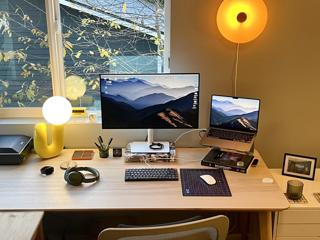

[You can ask Grok or your favorite vision model to roast your wrokstation setup](https://www.tomsguide.com/ai/i-just-had-elon-musks-grok-ai-rate-and-roast-the-desk-setups-of-toms-guide-editors) - Tom's Guide

___

[Tough choice for Apple in China, share AI tech or lobotomize phones](https://thehill.com/opinion/technology/4992881-apple-china-ai-dependence/)

___

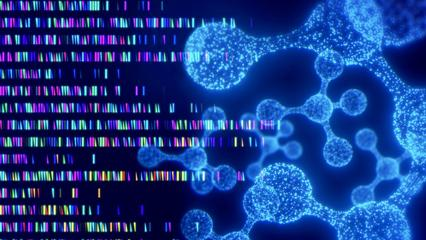

[LLM model does a good job predicting the effect of DNA mutations on protein structures.](https://www.livescience.com/technology/artificial-intelligence/meet-evo-an-ai-model-that-can-predict-the-effects-of-gene-mutations-with-unparalleled-accuracy) - livescience.com

___

[In Study, ChatGPT Beat Doctors at Diagnosing Illness](https://www.nytimes.com/2024/11/17/health/chatgpt-ai-doctors-diagnosis.html)

___

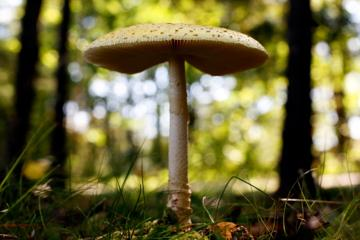

[How robots will kill us all: Uninvited Facebook chatbot joins mushroom chat and tells people to sauté poisonous mushrooms in butter.](https://www.yahoo.com/news/ai-chatbot-reportedly-says-eat-040304051.html) - Yahoo News

___

no more waiting on a long line to sit on the lap of a smelly old dude with a boner.

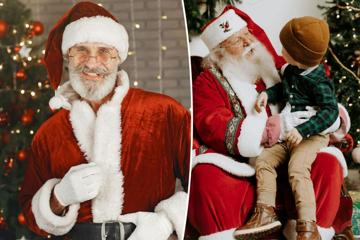

[This year kids can talk to robot Santas.](https://nypost.com/2024/11/16/lifestyle/kids-are-now-conversing-with-ai-powered-santa-claus-over-the-phone-big-tech-is-revolutionizing-christmas/) - New York Post

___

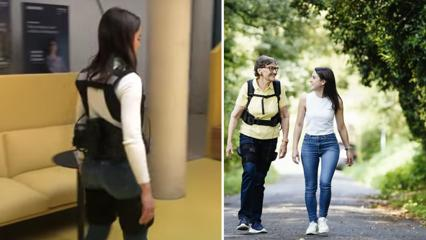

[Exoskeletons help seniors be more mobile.](https://www.yahoo.com/news/robotic-shorts-walking-jogging-easier-141048740.html) - Yahoo News

___

[Industries need explicit apprenticeship paths because AI taking over grunt work, plus remote work eliminating face-to-face mentorship, make it much harder for young people to break in and level up.](https://www.bloomberg.com/news/articles/2024-11-15/ai-replacing-entry-level-jobs-could-break-the-career-ladder)

___

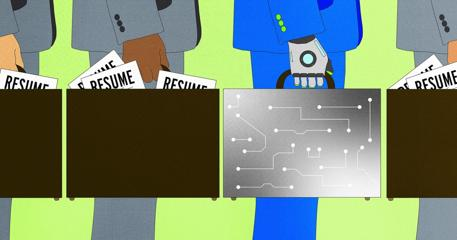

[AI technology allows users to apply to thousands of jobs per day, flooding job openings with resumes, that only AI can filter.](https://www.nbcnews.com/tech/innovation/ai-making-job-applications-easier-creating-another-problem-rcna179683) - NBC News

___

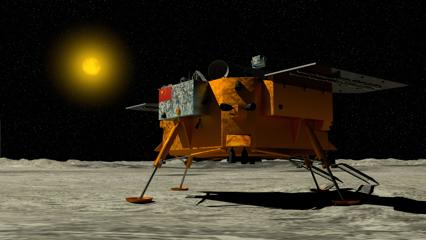

[Humanoid robot going to the moon in 2028](https://interestingengineering.com/space/humanoid-robot-could-join-china-mission-to-moon-2028) - Interesting Engineering

___

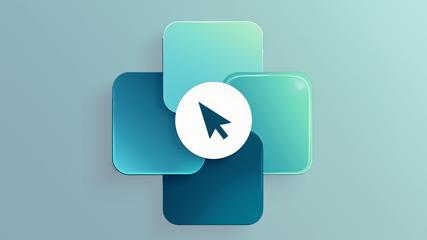

[An llms.txt standard has been proposed to specify how LLMs should scrape your content for AI training. (hopefully also which LLMs and what they can do)](https://the-decoder.com/new-llms-txt-web-standard-could-fundamentally-change-how-llms-read-and-process-online-content/) - THE DECODER

___

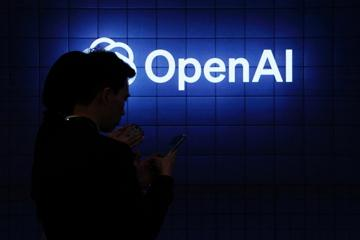

[Some juicy emails trickle out of OpenAI lawsuit](https://techcrunch.com/2024/11/15/openais-tumultuous-early-years-revealed-in-emails-from-musk-altman-and-others/) - TechCrunch

___

[One Year After Altman’s Ouster, OpenAI Remains Dominant (although competitors like Google, Claude, Qwen and Llama open-source models have dramatically narrowed the gap)](https://www.bloomberg.com/news/newsletters/2024-11-15/one-year-after-altman-s-ouster-openai-remains-dominant)

___

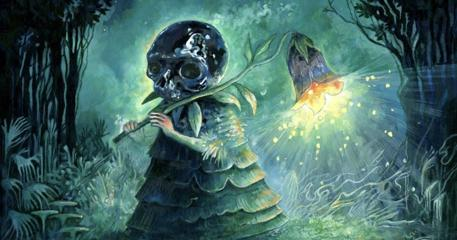

[OpenAI is not happy about artists using AI tools to poison image data.](https://80.lv/articles/openai-describes-artists-use-of-glaze-nightshade-as-abuse/)

___

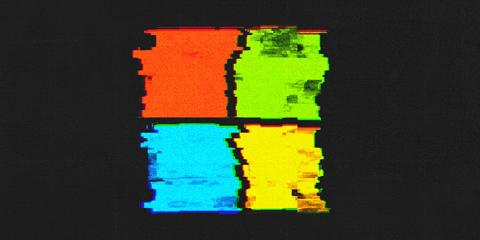

[Microsoft Copilot struggles in the enterprise, potential is obvious if not realized yet](https://www.businessinsider.com/microsoft-ai-artificial-intelligence-bet-doubts-marc-benioff-satya-nadella-2024-11) - Business Insider

___

Is Elon the new Borg Queen? discuss

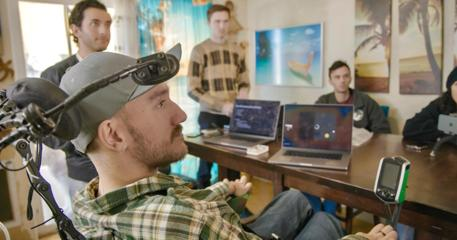

[An overview of the brain-computer interface landscape](https://www.digitaltrends.com/computing/tech-for-change-brain-computer-interface/) - Digital Trends

___

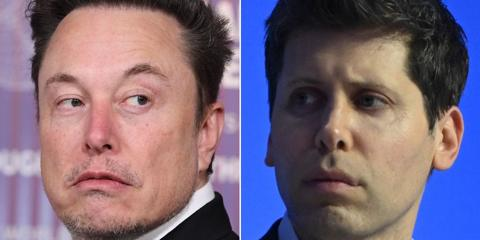

[The guy who just voted himself a \\$50b pay package, because  owning a big chunk of the company wasn't enough, complains OpenAI's comp is 'lavish' (also xAI is in a bidding war with OpenAI for AI talent and poaching AI researchers and devs from Tesla)](https://www.businessinsider.com/how-much-money-openai-employees-make-compensation-elon-musk-lawsuit-2024-11) - Business Insider

___

in this case, 'surge' = incrementally improve to a statistical tie, until OpenAI responds

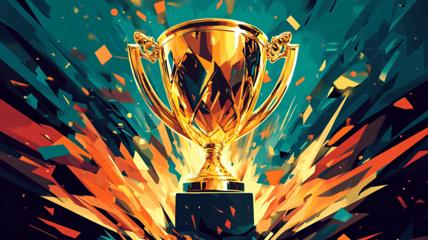

[I like VentureBeat's startup coverage but sometimes they are so technically AI illiterate. Like the Axios of tech coverage, let's write stuff down to the level of a 12-year-old so MBAs will understand it but completely mess it up](https://venturebeat.com/ai/google-gemini-unexpectedly-surges-to-no-1-over-openai-but-benchmarks-dont-tell-the-whole-story/) - VentureBeat

___

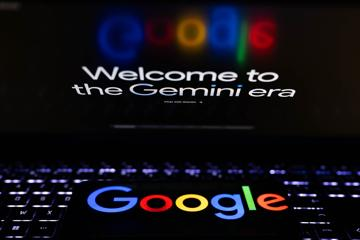

[Let's put the tech that hallucinates and spontaneously issues death threats into robots and drone swarms, what could go wrong?](https://www.vice.com/en/article/google-ai-chatbot-student-homework-help-please-die/) - VICE

___

[Letting chatbot technology run robots results in jailbreaks and ends about as you expect.](https://www.theregister.com/2024/11/16/chatbots_run_robots/)

___

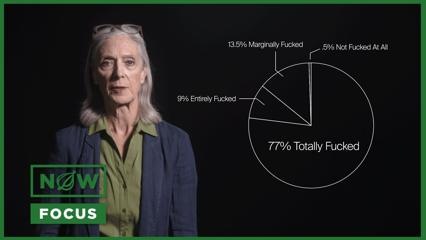

[TL; DR](https://www.youtube.com/watch?v=Bex5LyzbbBE) - YouTube

___

[An interview Future of Life Institute cofounder Max Tegmark on regulating AI.](https://www.fastcompany.com/91228731/max-tegmark-future-of-life-interview)

___

[Can transformers move from language to spatial understanding and robots and beyond?](https://www.wsj.com/tech/ai/a-powerful-ai-breakthrough-is-about-to-transform-the-world-095b81ea)

___

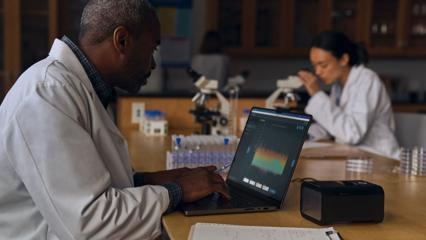

[Apple's Tim Millet and Tom Boger talk about their chip designs and strategy and AI neural engines](https://indianexpress.com/article/technology/tech-news-technology/exclusive-top-execs-explain-apple-chip-philosophy-9670865/) - The Indian Express

___

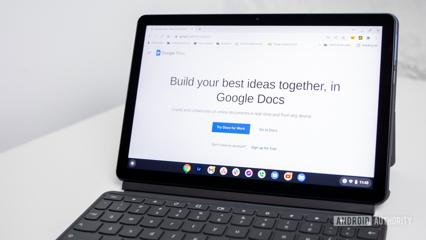

[When you click insert an image in Google Docs, you can now create an AI image on the fly](https://www.androidauthority.com/google-docs-inline-image-generation-3500239/) - Android Authority

___

why do robots always walk like they pooped their pants?

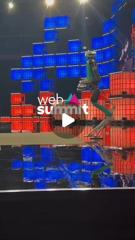

[Agility's Digit on stage at Web summit](https://www.instagram.com/reel/DCVmJu2RDty/) - Instagram

___

[Autonomous drones swarm Ukrainian skies. If an aircraft isn't remotely piloted, less comms to jam.](https://www.wsj.com/world/europe/ukraine-russia-war-ai-drones-9337f405)

___

[xAI raising another \\$6b to buy another 100,000 Nvidia GPUs](https://www.msn.com/en-us/money/companies/elon-musk-s-xai-raising-up-to-6-billion-to-purchase-100-000-nvidia-chips-for-memphis-data-center/ar-AA1u9jGr)

___

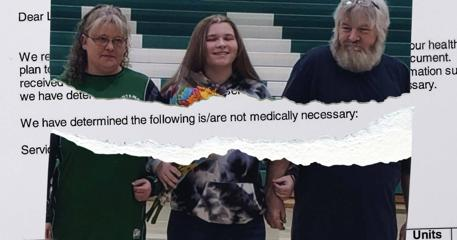

[Outsourced AI algorithm is behind insurance denials.](https://www.propublica.org/article/evicore-health-insurance-denials-cigna-unitedhealthcare-aetna-prior-authorizations?utm_campaign=propublica-sprout&utm_content=1731765603&utm_medium=social&utm_source=twitter) - ProPublica

___

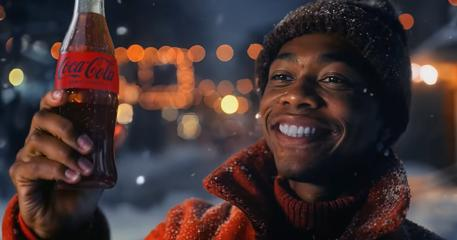

[Coke AI Christmas commercial raises some eyebrows](https://futurism.com/the-byte/coke-hideous-ai-commercial) - Futurism

___

[Study: People can’t reliably tell the difference between human and AI-generated poetry, prefer AI](https://theconversation.com/people-cant-tell-the-difference-between-human-and-ai-generated-poetry-new-study-243750)

___

[Study: ChatGPT helps creativity more than Google search](https://www.fastcompany.com/91228245/chatgpt-googling-better-creativity)

___

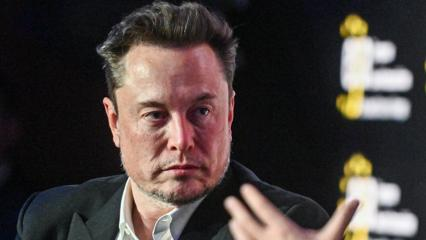

[Bluesky mocks X over TOS allowing AI training with no opt-out](https://www.thewrap.com/bluesky-mocks-x-rules-user-data-ai-training/) - TheWrap

___

[Sam Altman trolls Elon Musk](https://x.com/sama/status/1857570446910304645) - X (formerly Twitter)

___

[Musk’s X says California’s Deepfake Deception Act, requiring deletion of deceptive deepfakes, violates First Amendment](https://www.bloomberg.com/news/articles/2024-11-15/musk-s-x-sues-to-block-california-s-deepfake-deception-act)

___

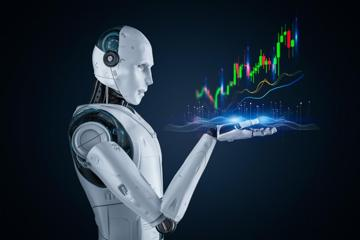

[Hyperscalers build their own silicon to evade the Nvidia tax](https://finance.yahoo.com/news/biggest-threat-nvidias-artificial-intelligence-100600862.html) - Yahoo Finance

___

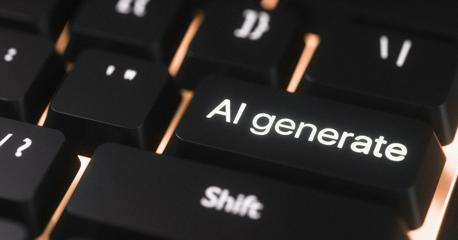

[Substacks use a lot of AI](https://www.wired.com/story/substacks-writers-use-ai-chatgpt/) - WIRED

___

[Promptim is another prompt engineering tool that can optimize prompts like DSPy, in the space of PromptLayer, promptfoo, I'm sure I forgot some](https://www.geeky-gadgets.com/promptim-ai-prompt-library/)

___

[Researchers find connections between LLMs and brain structures](https://www.geeky-gadgets.com/chatgpt-brain-like-structures/)

___

[ESPN is testing a possible on-air AI avatar dubbed 'FACTS'](https://awfulannouncing.com/espn/ai-avatar-facts-testing-stage-sec-nation.html)

___

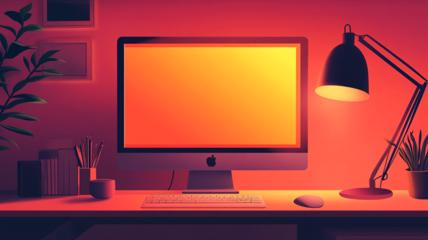

[Anthropic’s launches a prompt improver and other AI tools](https://venturebeat.com/ai/anthropic-new-ai-tools-promise-to-simplify-prompt-writing-and-boost-accuracy-by-30/) - VentureBeat

___

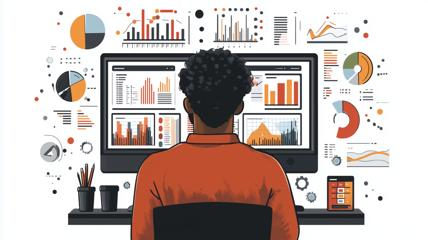

[Genspark, an AI-assisted search platform, adds fancy stock dataviz](https://venturebeat.com/ai/ai-search-wars-heat-up-genspark-adds-claude-powered-financial-reports-on-demand/) - VentureBeat

___

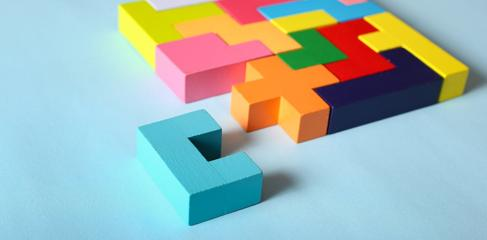

[How do you map language to something like a knowledge graph? When does 'Tammy is a vixen' mean she's a female fox?](https://theconversation.com/researchers-have-invented-a-new-system-of-logic-that-could-boost-critical-thinking-and-ai-242617) - The Conversation

___

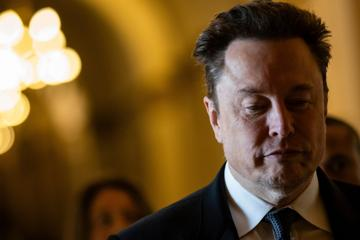

[Musk opens new front on Microsoft and OpenAI board members, particularly over terms restricting investments in xAI](https://techcrunch.com/2024/11/14/musks-amended-lawsuit-against-openai-names-microsoft-as-defendant/) - TechCrunch

___

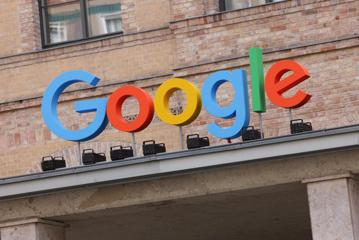

[François Chollet, creator of Keras AI framework, leaves Google to start a company](https://finance.yahoo.com/news/ai-pioneer-francois-chollet-leaves-160806671.html) - Yahoo Finance

___

name 'httplib' is not defined


[How AI Can Help Your Company Set a Budget](https://hbr.org/2024/11/how-ai-can-help-your-company-set-a-budget) - Harvard Business Review

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2024-11-17 10:19:05.937208


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 11, 17, 15, 16, 46, 947000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-11-16 04:19:05.945044


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [16]:
a

{'x': 1, 'y': 2}

In [17]:
b



NameError: name 'b' is not defined